# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Кулагин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w} = \frac{\partial\biggl(\sum_i \log(1 + e^{-y^{(i)} \langle w, x^{(j)}\rangle} + \frac{1}{C}\sum_i w_i^{2}\biggl)}{\partial w} = \sum_i{\frac{-y^{(i)}x^{(i)}}{1 + e^{y\langle w, x^{(i)} \rangle}}} + \frac{2}{C}\sum_i w_i$$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

def sigmoid(z): 
    return 1.0 / (1 + np.exp(-z))

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=10):
        """
        C - коэффициент регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        batch_size - размер batch'a
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        
    def h(self, x_elem):
        return sigmoid(-x_elem.dot(self.w))
    
    def grad(self, x, y_val):
        return x * (self.h(x) - y_val)

    def print_error(self, x, y):
        error = 0
        
        for i in range (x.shape[0]):
            error -= np.log(self.h(x[i])) * y[i] + (1 - np.log(self.h(x[i]))) * (1 - y[i])
        
        return error
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        
        self.errors = []
        
        self.w = np.ones(x.shape[1])

        for epoch_num in range (1, self.max_epoch + 1):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            
            local_error = 0
                        
            alpha_epoch_num = self.alpha / epoch_num
            
            for batch_num in range (0, self.batch_size):
                curr_indices = indices[batch_num:batch_num + self.batch_size]
                
                for i in curr_indices:
                    self.w += alpha_epoch_num * self.grad(x[i], y[i])
                    
                    for idx_w in range(self.w.shape[0]): # L2-регуляризация
                        self.w[idx_w] -= 2.0 / self.C * (alpha_epoch_num) * self.w[idx_w]
            
            self.errors.append(self.print_error (x, y))
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = []
        
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        
        for i in range (x.shape[0]):
            if self.h (x[i]) > 0.5:
                y_hat.append(1)
            else:
                y_hat.append(0)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = []
        
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        
        for i in range (x.shape[0]):
            y_hat_proba.append (self.h (x[i]))
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

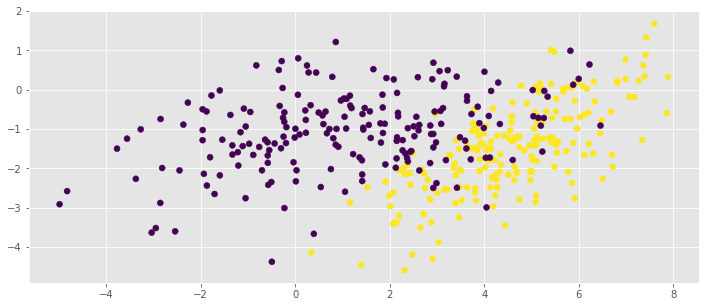

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
model = MySGDClassifier(C=200, alpha=0.1, max_epoch=300, batch_size=10)
model.fit(X, y)

MySGDClassifier(C=200, alpha=0.1, batch_size=10, max_epoch=300)

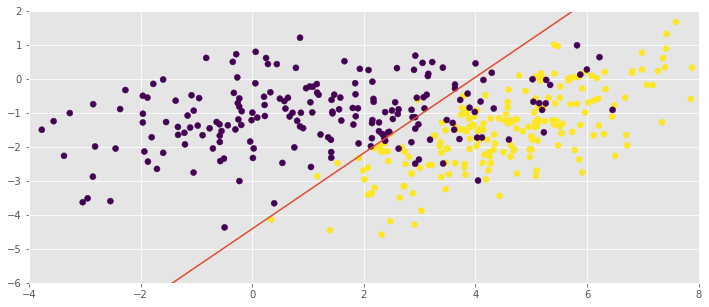

In [6]:
plt.plot([-4,8], [(4 * model.w[0] - model.w[2]) / model.w[1], (-8* model.w[0] - model.w[2]) / model.w[1]])
plt.scatter(X[:,0], X[:,1], c=y)

axes = plt.gca()

axes.set_xlim([-4,8])
axes.set_ylim([-6,2])

plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [7]:
from sklearn.datasets import make_classification

In [46]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

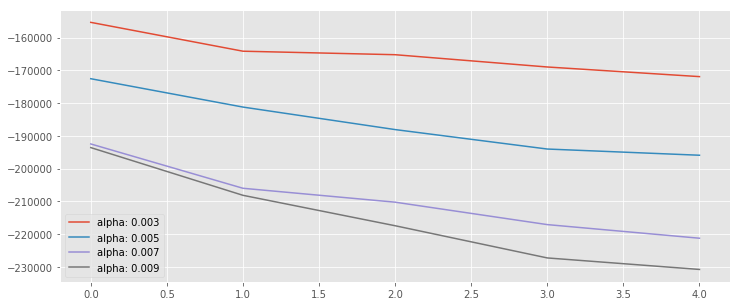

In [47]:
## Your Code Here
for alpha in np.arange(3e-3, 1e-2, 2e-3):
    model = MySGDClassifier(C=200, alpha=alpha, max_epoch=5, batch_size=10)
    model.fit(X, y)
    
    plt.plot(model.errors, label='alpha: ' + str(alpha))

plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

/home/alexfmsu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/alexfmsu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/alexfmsu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


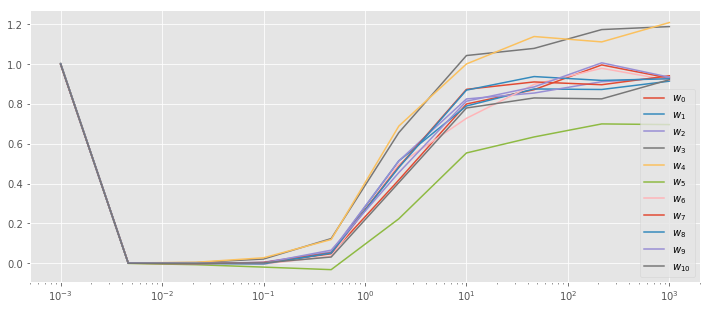

In [49]:
## Your Code Here
w = np.empty([10, 1+X.shape[1]])

for i, c in enumerate(np.logspace(3, -3, 10)):
    model = MySGDClassifier(alpha=3.0e-3, C=c, max_epoch=5)
    model.fit(X, y)
    
    w[i] = model.w
    
for i in range(w.shape[1]):
    lbl = r'w_{}'.format(i)
    
    plt.plot(np.logspace(3, -3, 10), w[:, i], label=r'$w_{%d}$' % i)
    plt.xscale('log')

plt.legend()